# Jaccard Analysis

## Imports

In [42]:
import sys
import os
import math
import ast
from pathlib import Path
from tqdm import tqdm
import numpy as np
from itertools import combinations, combinations_with_replacement
import pandas as pd
import random
from cycler import cycler
from functools import reduce
from scipy.signal import fftconvolve
from scipy.ndimage import rotate
from skimage.metrics import structural_similarity
from sklearn.preprocessing import StandardScaler

# imports from ../scripts directory
sys.path.append(os.path.abspath(os.path.join("..", "scripts")))
from common import *

import matplotlib

params = {"axes.prop_cycle": cycler(color=PICKER_COLORS)}
matplotlib.rcParams.update(params)

import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
from matplotlib import patches
from matplotlib import patheffects
from matplotlib_venn import (
    venn2_unweighted,
    venn2_circles,
    venn3_unweighted,
    venn3_circles,
)

%matplotlib inline

## Parameters

In [48]:
# graphing
x_thresholds = range(0, 101)  # 0 to 100
x_ticks = [0, 35, 60, 75, 100]
barh_thresholds = [1, 20, 40, 60, 80, 90, 95]

# paths
dataset_name = "EMPIAR 10017"
out_dir = Path("~/Downloads/grs_10017/").expanduser()
one_many_matches = read_from_pickle(out_dir / "one_many_matches.pickle")
maxbpt_matches = read_from_pickle(out_dir / "maxbpt_matches.pickle")

mrc_key = "mrc"
gt_key = "gt"
picker_names = list(set(one_many_matches.keys()) - {mrc_key, gt_key})

venn_picker_lists = [
    ["cryolo", "topaz", "deeppicker"],
    ["cryolo", "autocryopicker", "parsed"],
]

## Helpers

In [44]:
def adjust_plot_attributes(ax,xlabel,ylabel):
    """adjust common matplotlib plot parameters"""
    for axis in ["bottom"]:
        ax.spines[axis].set_visible(True)
        ax.spines[axis].set_color('k')
    ax.spines[axis].set_linewidth(1.0)
    handles,labels=ax.get_legend_handles_labels()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_ylabel(ylabel,fontsize=16)
    ax.set_xlabel(xlabel,fontsize=16)
    ax.tick_params(axis='x',which="both",bottom=True,top=False,direction="out",
        length=4,width=1.0,color='k',labelsize=16)
    ax.tick_params(axis='y',which="both",left=False,right=False,direction="out",
        length=4,width=1.0,color='k',labelsize=16)
    ax.grid(color="gray",ls=':',lw=0.5)

## Plotting

### With-replacement and max. bipartite Jaccard line plots

In [45]:
# graph options
mrc_path = None  # set to None to plot a summary
show_picker_totals=False

In [49]:
# load data
jac_df = pd.DataFrame(one_many_matches)
maxbpt_df = pd.DataFrame(maxbpt_matches)

# filter data
if mrc_path is None:
    gt_boxes = [Box(*v) for v in jac_df[gt_key] if v is not None]
    jac_df_filt = jac_df
    maxbpt_df_filt = maxbpt_df
else:
    gt_boxes = [
        Box(*v)
        for v in jac_df[jac_df[mrc_key] == mrc_path][gt_key]
        if v is not None
    ]
    jac_df_filt = jac_df.loc[jac_df[mrc_key] == mrc_path]
    maxbpt_df_filt = maxbpt_df[maxbpt_df[mrc_key] == mrc_path]

gt_len = len(gt_boxes)

# make jac and maxbpt lines for each picker
jac_lines = []
maxbpt_lines = []
for pckr in picker_names:
    jac_scores = [v[1] for r in jac_df_filt[pckr] for v in r]
    maxbpt_scores = [v[1] for r in maxbpt_df_filt[pckr] for v in r]
    jac_line = [sum(1 for j in jac_scores if j >= t / 100) for t in x_thresholds]
    jac_lines.append(jac_line)
    maxbpt_line = [
        sum(1 for i in maxbpt_scores if i >= t / 100)
        for t in x_thresholds
    ]
    maxbpt_lines.append(maxbpt_line)

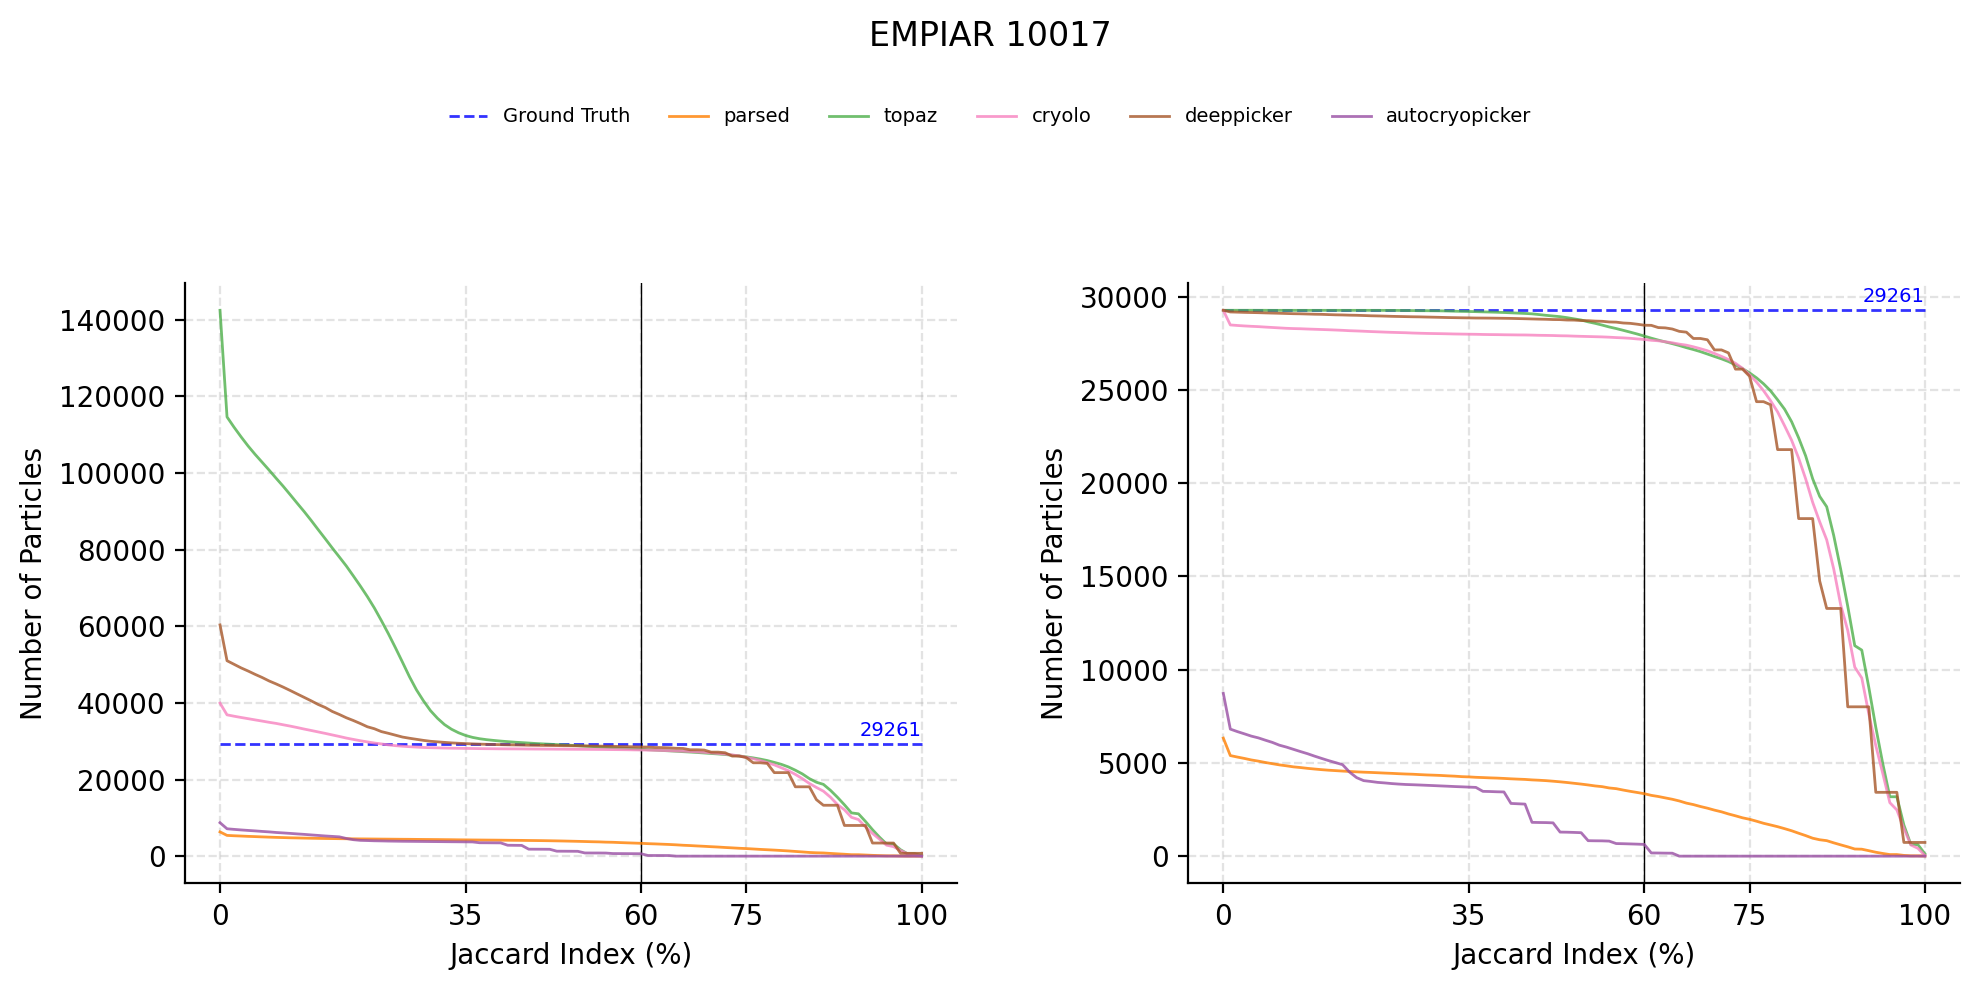

In [50]:
# make figure
num_subplots = 2
fig_size = (5 * num_subplots, 5)
jac_fig, jac_ax = plt.subplots(
    nrows=1, ncols=num_subplots, figsize=fig_size, dpi=200, squeeze=False
)

# build first two subplots
subplot_names = {0: "", 1: ""}
subplot_lines = {0: jac_lines, 1: maxbpt_lines}
for sp_idx, sp_name in subplot_names.items():
    jac_ax[0, sp_idx].set_title(sp_name, fontsize=10, pad=15)
    jac_ax[0, sp_idx].set_prop_cycle(cycler(color=PICKER_COLORS))
    legend_list = picker_names

    # plot manual line 
    # (only add label for the first algorithm to avoid duplicate legend entries)
    jac_ax[0, sp_idx].plot(
        x_thresholds,
        [gt_len] * len(x_thresholds),
        color=GT_COLOR,
        linestyle="dashed",
        linewidth=1.0,
        alpha=0.8,
        label="Ground Truth" if sp_idx == 0 else "",
    )

    # plot 60% vline
    jac_ax[0, sp_idx].axvline(60, color="k", lw=0.5)

    # plot picker lines
    picker_lines = []
    for i, pckr_line in enumerate(subplot_lines[sp_idx]):
        ln = jac_ax[0, sp_idx].plot(
            x_thresholds,
            pckr_line,
            linewidth=1.0,
            alpha=0.8,
            label=legend_list[i] if sp_idx == 0 else "",
        )
        picker_lines.append(ln)

    # formatting
    jac_ax[0, sp_idx].set_xticks(x_ticks)
    jac_ax[0, sp_idx].set_xlabel("Jaccard Index (%)")
    jac_ax[0, sp_idx].set_ylabel("Number of Particles")
    # hide right and top axis spines
    jac_ax[0, sp_idx].spines["right"].set_visible(False)
    jac_ax[0, sp_idx].spines["top"].set_visible(False)
    # add grid
    jac_ax[0, sp_idx].grid(alpha=0.35, linestyle="dashed")

    # add manual line label
    jac_ax[0, sp_idx].annotate(
        str(round(gt_len, 1)),
        (100, gt_len),
        textcoords="offset points",  # positioning
        color=GT_COLOR,
        fontsize=7,
        xytext=(0, 3),  # offset between point and label
        ha="right",
    )  # horizontal alignment

    # add picker data labels at major x-ticks
    # while also making sure that no labels overlap
    text_bboxes = []
    if show_picker_totals:
        for idx, pckr_line in enumerate(subplot_lines[sp_idx]):
            for i, val in enumerate(pckr_line):
                if i == x_ticks[0]:  # only plot the first point
                    lbl = jac_ax[0, sp_idx].annotate(
                        str(round(val, 1)),
                        (i, val),
                        textcoords="offset points",
                        color=picker_lines[idx][0].get_color(),
                        fontsize=7,
                        xytext=(0, 2),
                        ha="left",
                        va="bottom",
                    )
                    l_bbox = lbl.get_window_extent(
                        renderer=jac_fig.canvas.get_renderer()
                    )
                    l_bbox = l_bbox.transformed(
                        jac_ax[0, sp_idx].transData.inverted()
                    )

                    # calculate label positioning via "surround" method
                    text_pos_options = [
                        (-1, -3, "right", "top"),
                        (1, -3, "left", "top"),
                        (-1, 3, "right", "bottom"),
                        (1, 9, "left", "bottom"),
                        (-1, -9, "right", "top"),
                        (1, -9, "left", "top"),
                        (-1, 9, "right", "bottom"),
                        (1, 15, "left", "bottom"),
                    ]

                    for text_pos in text_pos_options:
                        lbl_box = Box(
                            l_bbox.x0,
                            l_bbox.y0 - 2,
                            l_bbox.x1 - l_bbox.x0,
                            l_bbox.y1 - l_bbox.y0 + 4,
                        )
                        is_pos_bad = sum(
                            1
                            for b in text_bboxes
                            if sp.jaccard_minmax(
                                Box(b.x0, b.y0 - 2, b.x1 - b.x0, b.y1 - b.y0 + 4),
                                lbl_box,
                            )
                            > 0
                        )
                        if is_pos_bad:
                            lbl.remove()
                            lbl = jac_ax[0, sp_idx].annotate(
                                str(round(val, 1)),
                                (i, val),
                                textcoords="offset points",
                                color=picker_lines[idx][0].get_color(),
                                fontsize=7,
                                xytext=(text_pos[0], text_pos[1]),
                                ha=text_pos[2],
                                va=text_pos[3],
                            )
                            l_bbox = lbl.get_window_extent(
                                renderer=jac_fig.canvas.get_renderer()
                            )
                            l_bbox = l_bbox.transformed(
                                jac_ax[0, sp_idx].transData.inverted()
                            )
                        else:
                            text_bboxes.append(l_bbox)
                            break

# generate legend
legend = jac_fig.legend(
    bbox_to_anchor=(0.5, 0.91),
    loc="upper center",
    fontsize=7,
    ncol=7,
    frameon=False,
)
extra_artists = [legend]

mrc_name = (
    dataset_name
    if mrc_path is None
    else ut.basename(mrc_path, mode="name")
)
extra_artists.append(jac_fig.suptitle(mrc_name))

# resize and write out
jac_fig.tight_layout(
    rect=(0, 0, 1, 0.86 - 0.025 * math.ceil((len(picker_names) + 1) / 4))
)

jac_fig.subplots_adjust(wspace=0.3)
plt.show()

### True-positive agreement Venn diagrams

In [5]:
def plot_tpvenn(mrc_path):
    if mrc_path is None:
        maxbpt_dfs_filtered = maxbpt_dfs.copy()
    else:
        maxbpt_dfs_filtered = {
            p: df[df["mrc"] == mrc_path] for p, df in maxbpt_dfs.items()
        }
    
    # replace gt_* and pckr_* cols in maxbpt_dfs_filtered with Box namedtuples
    for pckr_name, df in maxbpt_dfs_filtered.items():
        gt_boxes = im.df_filter_cols(
            df, "gt", col_names=["x", "y", "w", "h"]
        ).itertuples(name="Box", index=False)

        pckr_boxes = im.df_filter_cols(
            df, "pckr", col_names=Box._fields
        ).itertuples(name="Box", index=False)

        jac_vals = df["jac"].tolist()
        df_rows = list(zip(list(gt_boxes), list(pckr_boxes), jac_vals))
        
        maxbpt_dfs_filtered[pckr_name] = pd.DataFrame(
            df_rows, columns=["gt", pckr_name, pckr_name + "_jac"]
        )

    # merge dataframes by finding their union ('outer') in pairs using reduce
    # note: suffixes can only be (None, None) if columns to be merged have different names
    merged_df = reduce(
        lambda lhs, rhs: pd.merge(
            lhs, rhs, how="outer", on=["gt"], suffixes=(None, None)
        ),
        maxbpt_dfs_filtered.values(),
    )

    # replace any picker boxes whose Jaccard index is less than cfg['tpvenn_jac_tpt'] with NaN
    # if tpvenn_jac_tpt was set to 0, ensure that boxes with jac = 0 are removed (they're not actual matches)
    for pckr in picker_names:
        if cfg["tpvenn_jac_tpt"] == 0:
            merged_df.loc[merged_df[pckr + "_jac"] == 0, pckr] = np.nan
        else:
            merged_df.loc[
                merged_df[pckr + "_jac"] < cfg["tpvenn_jac_tpt"], pckr
            ] = np.nan

    # subsets for 2-circle venns a, b: [a, b, ab]
    # subsets for 3-circle venns a, b, c: [a, b, ab, c, ac, bc, abc]
    all_subsets = []
    tp_counts = {
        p: len(merged_df[merged_df[p].notnull()].index) for p in picker_names
    }
    tp_totals = []

    for venn_pckrs in venn_picker_lists:

        # add to tp_totals
        tp_totals.append([tp_counts[p] for p in venn_pckrs])

        # if this is a 2-circle venn
        if len(venn_pckrs) == 2:
            pa, pb = venn_pckrs
            a = merged_df[merged_df[pa].notnull() & merged_df[pb].isnull()]
            b = merged_df[merged_df[pa].isnull() & merged_df[pb].notnull()]
            ab = merged_df[merged_df[pa].notnull() & merged_df[pb].notnull()]
            all_subsets.append([len(df.index) for df in (a, b, ab)])

        # if this is a 3-circle venn
        elif len(venn_pckrs) == 3:
            pa, pb, pc = venn_pckrs
            a = merged_df[
                merged_df[pa].notnull()
                & merged_df[pb].isnull()
                & merged_df[pc].isnull()
            ]
            b = merged_df[
                merged_df[pa].isnull()
                & merged_df[pb].notnull()
                & merged_df[pc].isnull()
            ]
            ab = merged_df[
                merged_df[pa].notnull()
                & merged_df[pb].notnull()
                & merged_df[pc].isnull()
            ]
            c = merged_df[
                merged_df[pa].isnull()
                & merged_df[pb].isnull()
                & merged_df[pc].notnull()
            ]
            ac = merged_df[
                merged_df[pa].notnull()
                & merged_df[pb].isnull()
                & merged_df[pc].notnull()
            ]
            bc = merged_df[
                merged_df[pa].isnull()
                & merged_df[pb].notnull()
                & merged_df[pc].notnull()
            ]
            abc = merged_df[
                merged_df[pa].notnull()
                & merged_df[pb].notnull()
                & merged_df[pc].notnull()
            ]
            all_subsets.append([len(df.index) for df in (a, b, ab, c, ac, bc, abc)])

        else:
            print(
                "Found list of length %s in venn_index_lists; each list should "
                "contain either 2 or 3 picker indices"
                % len(venn_pckrs)
            )
            continue

    # make figure
    ncols = len(venn_picker_lists)
    fig_size = (6 * ncols, 6)
    tpv_fig, tpv_ax = plt.subplots(
        nrows=1, ncols=ncols, figsize=fig_size, dpi=200, squeeze=False
    )

    extra_artists = []

    venn_labels = [
        list(zip(*[
            (pckr, PICKER_COLORS[picker_names.index(pckr)])
            for pckr in pckrs
        ])) for pckrs in venn_picker_lists
    ]

    for ax_idx, subsets in enumerate(all_subsets):
        this_labels = [
            str(venn_labels[ax_idx][0][i]) + "\n$\it{N}$ = " + str(tp_totals[ax_idx][i])
            for i in range(len(venn_labels[ax_idx][0]))
        ]
        # 2-circle Venn diagrams will be described by 3 numbers (see above)
        if len(subsets) == 3:
            v = venn2_unweighted(
                subsets=subsets,
                set_labels=this_labels,
                set_colors=venn_labels[ax_idx][1],
                ax=tpv_ax[0][ax_idx],
            )
            extra_artists.extend([v.get_label_by_id("A"), v.get_label_by_id("B")])
            # venn2_circles(subsets=subsets, linestyle='solid', linewidth=1, color='k', ax=tpv_ax[0][ax_idx])
            venn2_circles(
                subsets=(1, 1, 1),
                linestyle="solid",
                linewidth=1,
                color="k",
                ax=tpv_ax[0][ax_idx],
            )  # subsets are all 1 for this so the positions are unweighted
        # 3-circle Venn diagrams will be described by 7 numbers (see above)
        elif len(subsets) == 7:
            v = venn3_unweighted(
                subsets=subsets,
                set_labels=this_labels,
                set_colors=venn_labels[ax_idx][1],
                ax=tpv_ax[0][ax_idx],
            )
            extra_artists.extend(
                [
                    v.get_label_by_id("A"),
                    v.get_label_by_id("B"),
                    v.get_label_by_id("C"),
                ]
            )
            # venn3_circles(subsets=subsets, linestyle='solid', linewidth=1, color='k', ax=tpv_ax[0][ax_idx])
            venn3_circles(
                subsets=(1, 1, 1, 1, 1, 1, 1),
                linestyle="solid",
                linewidth=1,
                color="k",
                ax=tpv_ax[0][ax_idx],
            )  # subsets are all 1 for this so the positions are unweighted
        else:
            print(
                "Venn diagram picker lists need to be of length 2 or 3. Skipping."
            )

    # formatting
    mrc_name = (
        cfg["dataset_name"]
        if mrc_path is None
        else ut.basename(mrc_path, mode="name")
    )
    extra_artists.append(
        tpv_fig.suptitle(
            "True-Positive Agreement\n"
            + r"IoU$_{TP}$ ≥ %s, Confidence ≥ %s"
            % (cfg["tpvenn_jac_tpt"], cfg["tpvenn_conf_thresh"])
            + "\n(%s)" % mrc_name,
            y=1.05,
        )
    )
    tpv_fig.tight_layout(rect=(0, 0, 1, 0.94))

    plt.show()

### Max. bipartite detection quality stacked bar plot

In [43]:
def plot_stackedbar():
    # build color dict
    color_dict = {
        "gt": [
            ut.scale_color_brightness(LIGHTBLUE_GLOBAL, n)
            for n in np.linspace(1.0, 2.0, num=8)[::-1]
        ]
    }
    color_scale = {
        PICKER_COLORS[0]: 1.8,  # orange
        PICKER_COLORS[1]: 1.8,  # green
        PICKER_COLORS[2]: 1.3,  # pink
        PICKER_COLORS[3]: 2.2,  # brown
        PICKER_COLORS[4]: 2.0,  # purple
        PICKER_COLORS[5]: 1.8,
        PICKER_COLORS[6]: 1.8
    }
    for p in picker_names:
        color = PICKER_COLORS[picker_names.index(p)]
        color_dict[p] = [
            ut.scale_color_brightness(color, n)
            for n in np.linspace(1.0, color_scale[color], num=8)[::-1]
        ]

    # get box and maxbpt counts
    count_dict = {}
    for pckr, df in box_dfs.items():
        box_counts = df.groupby("mrc").size()
        count_dict[pckr] = {m: int(box_counts[m]) for m in box_counts.index}
    count_dict["gt"] = {m: len(all_gt_boxes[m]) for m in all_gt_boxes.keys()}

    mbpt_dict = {}
    for pckr, df in maxbpt_dfs.items():
        df_by_mrc = df[df["jac"] > 0].groupby("mrc")
        mbpt_dict[pckr] = {m: group["jac"].tolist() for m, group in df_by_mrc}

    # calculate total number of GT particles
    N_gt = np.sum(list(count_dict["gt"].values()))
    mrc_gt = len(count_dict["gt"].keys())

    # iterate over pickers and calculate counts
    barh_fig, barh_ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), dpi=300)
    pickers = sorted(mbpt_dict.keys())
    barh_ax.set_ylim([-1, len(pickers)])

    for i, picker in enumerate(pickers):
        x, y = [], []

        # calculate total number of picker detections/particles
        N = np.sum(list(count_dict[picker].values()))

        assert (
            len(count_dict[picker].keys()) == mrc_gt
        ), "Error - different number of mrcs observed by GT and '{}'".format(picker)

        # plot stack bars
        total = 0
        left = (len(barh_thresholds) + 1) * [0]
        barh_ax.barh(
            i,
            N_gt * -1,
            left=left,
            color=color_dict["gt"][0],
            edgecolor=color_dict["gt"][len(color_dict["gt"]) // 2],
        )
        barh_ax.barh(
            i,
            N,
            left=left,
            color=color_dict[picker][0],
            edgecolor=color_dict[picker][len(color_dict[picker]) // 2],
        )
        for j, thres in enumerate(barh_thresholds, 1):
            count = np.sum(
                [
                    np.sum([
                        1 if val > thres / 100 else 0
                        for val in mbpt_dict[picker][key]
                    ]) for key in mbpt_dict[picker].keys()
                ]
            )
            barh_ax.barh(
                i,
                count * -1,
                left=left,
                color=color_dict["gt"][j],
                edgecolor=color_dict["gt"][len(color_dict["gt"]) // 2],
            )
            barh_ax.barh(
                i,
                count,
                left=left,
                color=color_dict[picker][j],
                edgecolor=color_dict[picker][
                    len(color_dict[picker]) // 2
                ],
            )

    # plot vertical line at x = 0
    barh_ax.vlines(0, -1, len(pickers), color="k", lw=1)

    # plot gt/picker label at top
    lbl_frac = 0.15 * N_gt
    barh_ax.annotate(
        "GT", 
        xy=(-lbl_frac, 1),
        xycoords=("data", "axes fraction"), 
        fontsize="xx-large",
        ha="right", 
        va="bottom"
    )
    barh_ax.annotate(
        "Picker", 
        xy=(lbl_frac, 1),
        xycoords=("data", "axes fraction"), 
        fontsize="xx-large",
        ha="left", 
        va="bottom"
    )

    del i, picker, x, y, total, left, j, thres, count

    # remove negative sign from negative x ticks
    barh_fig.canvas.draw()
    labels = [
        item.get_text() if ut.has_numbers(item.get_text()[0]) else item.get_text()[1:]
        for item in barh_ax.get_xticklabels()
    ]
    
    barh_ax.set_xticklabels(labels, ha="left", rotation=-30)
    barh_ax.set_yticks(range(0, len(pickers), 1))
    barh_ax.set_yticklabels(pickers)

    # setup custom color bar
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "Greys",
        [
            "#4d4d4d",
            "#616161",
            "#767676",
            "#8b8b8b",
            "#a1a1a1",
            "#b7b8b8",
            "#cecfcf",
            "#e6e7e7",
        ],
    )
    N = len(barh_thresholds) + 2
    splits = range(N)
    norm = matplotlib.colors.BoundaryNorm(splits, cmap.N)

    # create axis for color bar
    axins1 = inset_axes(barh_ax, width="33%", height="2.5%", loc="upper right")

    # plot color bar
    cbar = barh_fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=axins1,
        ticks=splits,
        orientation="horizontal",
    )
    tick_locs = np.arange(N) + 0.5
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(barh_thresholds[::-1] + ["0"])
    cbar.ax.set_title("Jaccard Index (%)")

    adjust_plot_attributes(barh_ax, "Number of particles", "")
    plt.show()

## Summary plots

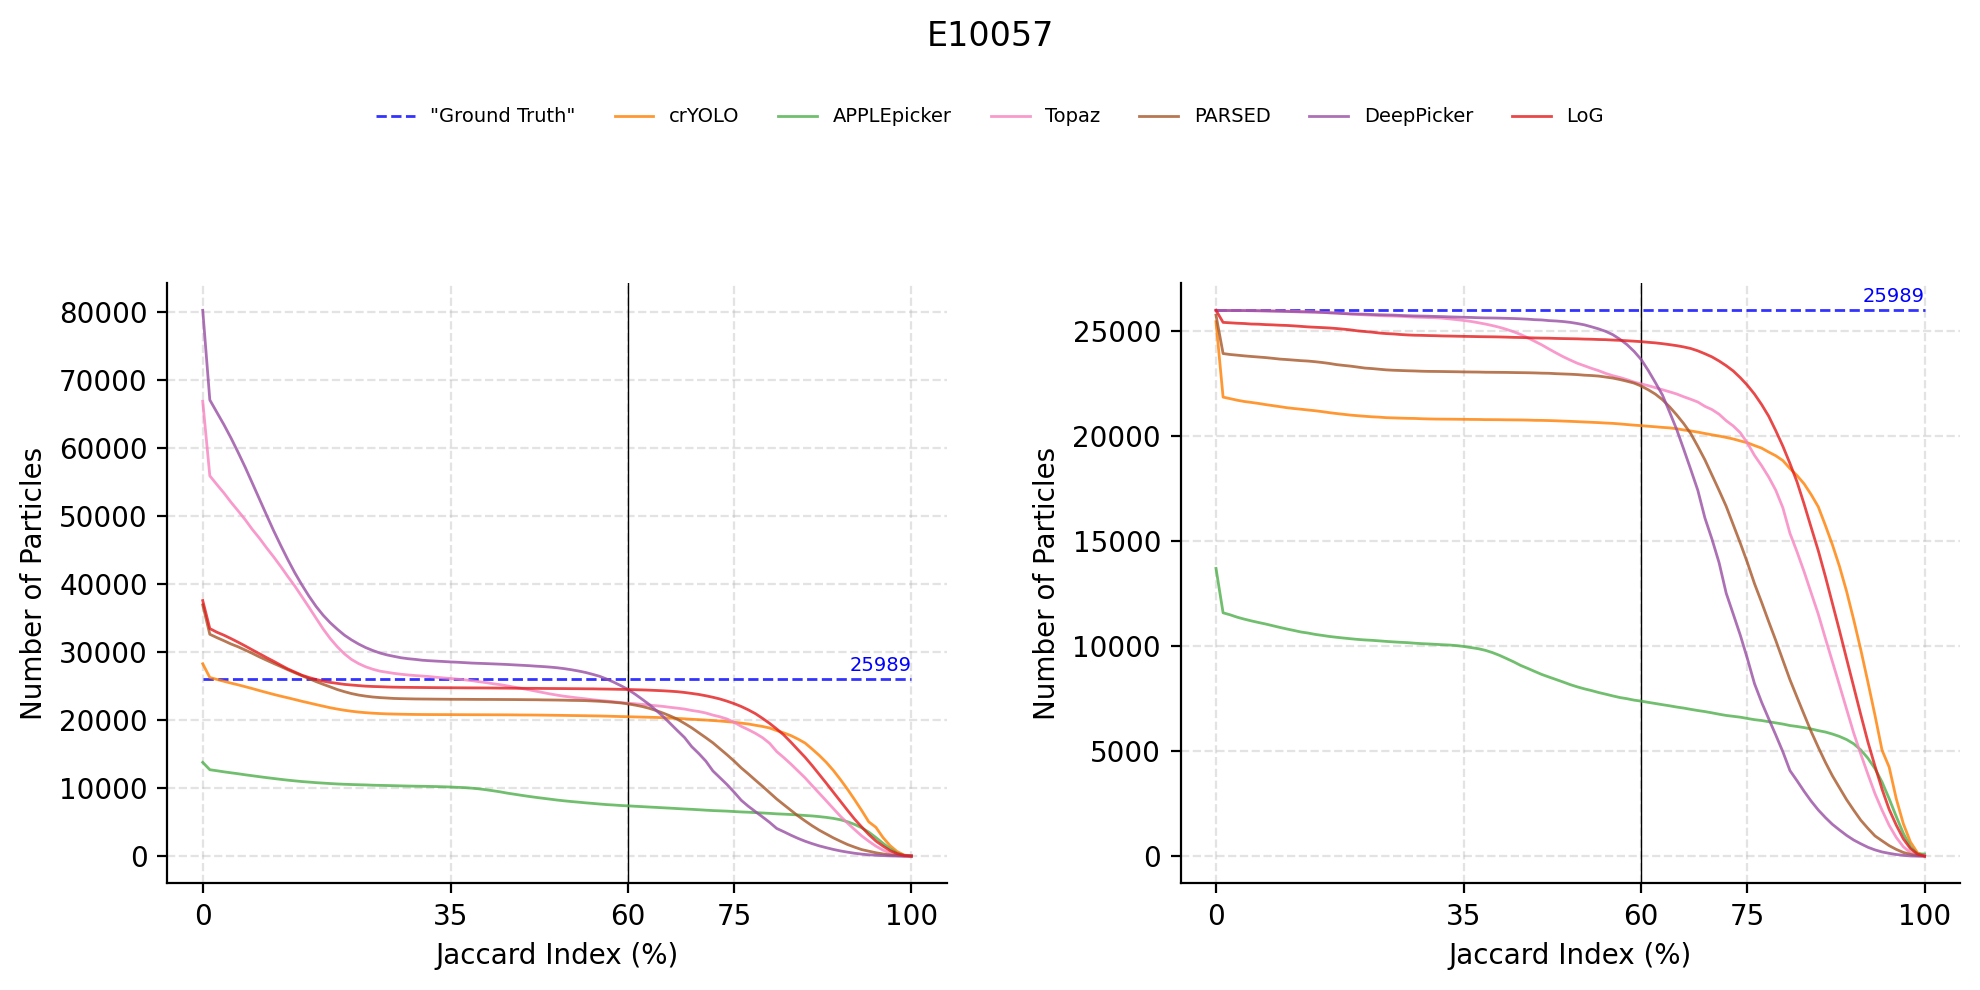

In [50]:
plot_jac(None)

<ipython-input-43-3d77eb1840c0>:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  barh_ax.set_xticklabels(labels, ha="left", rotation=-30)


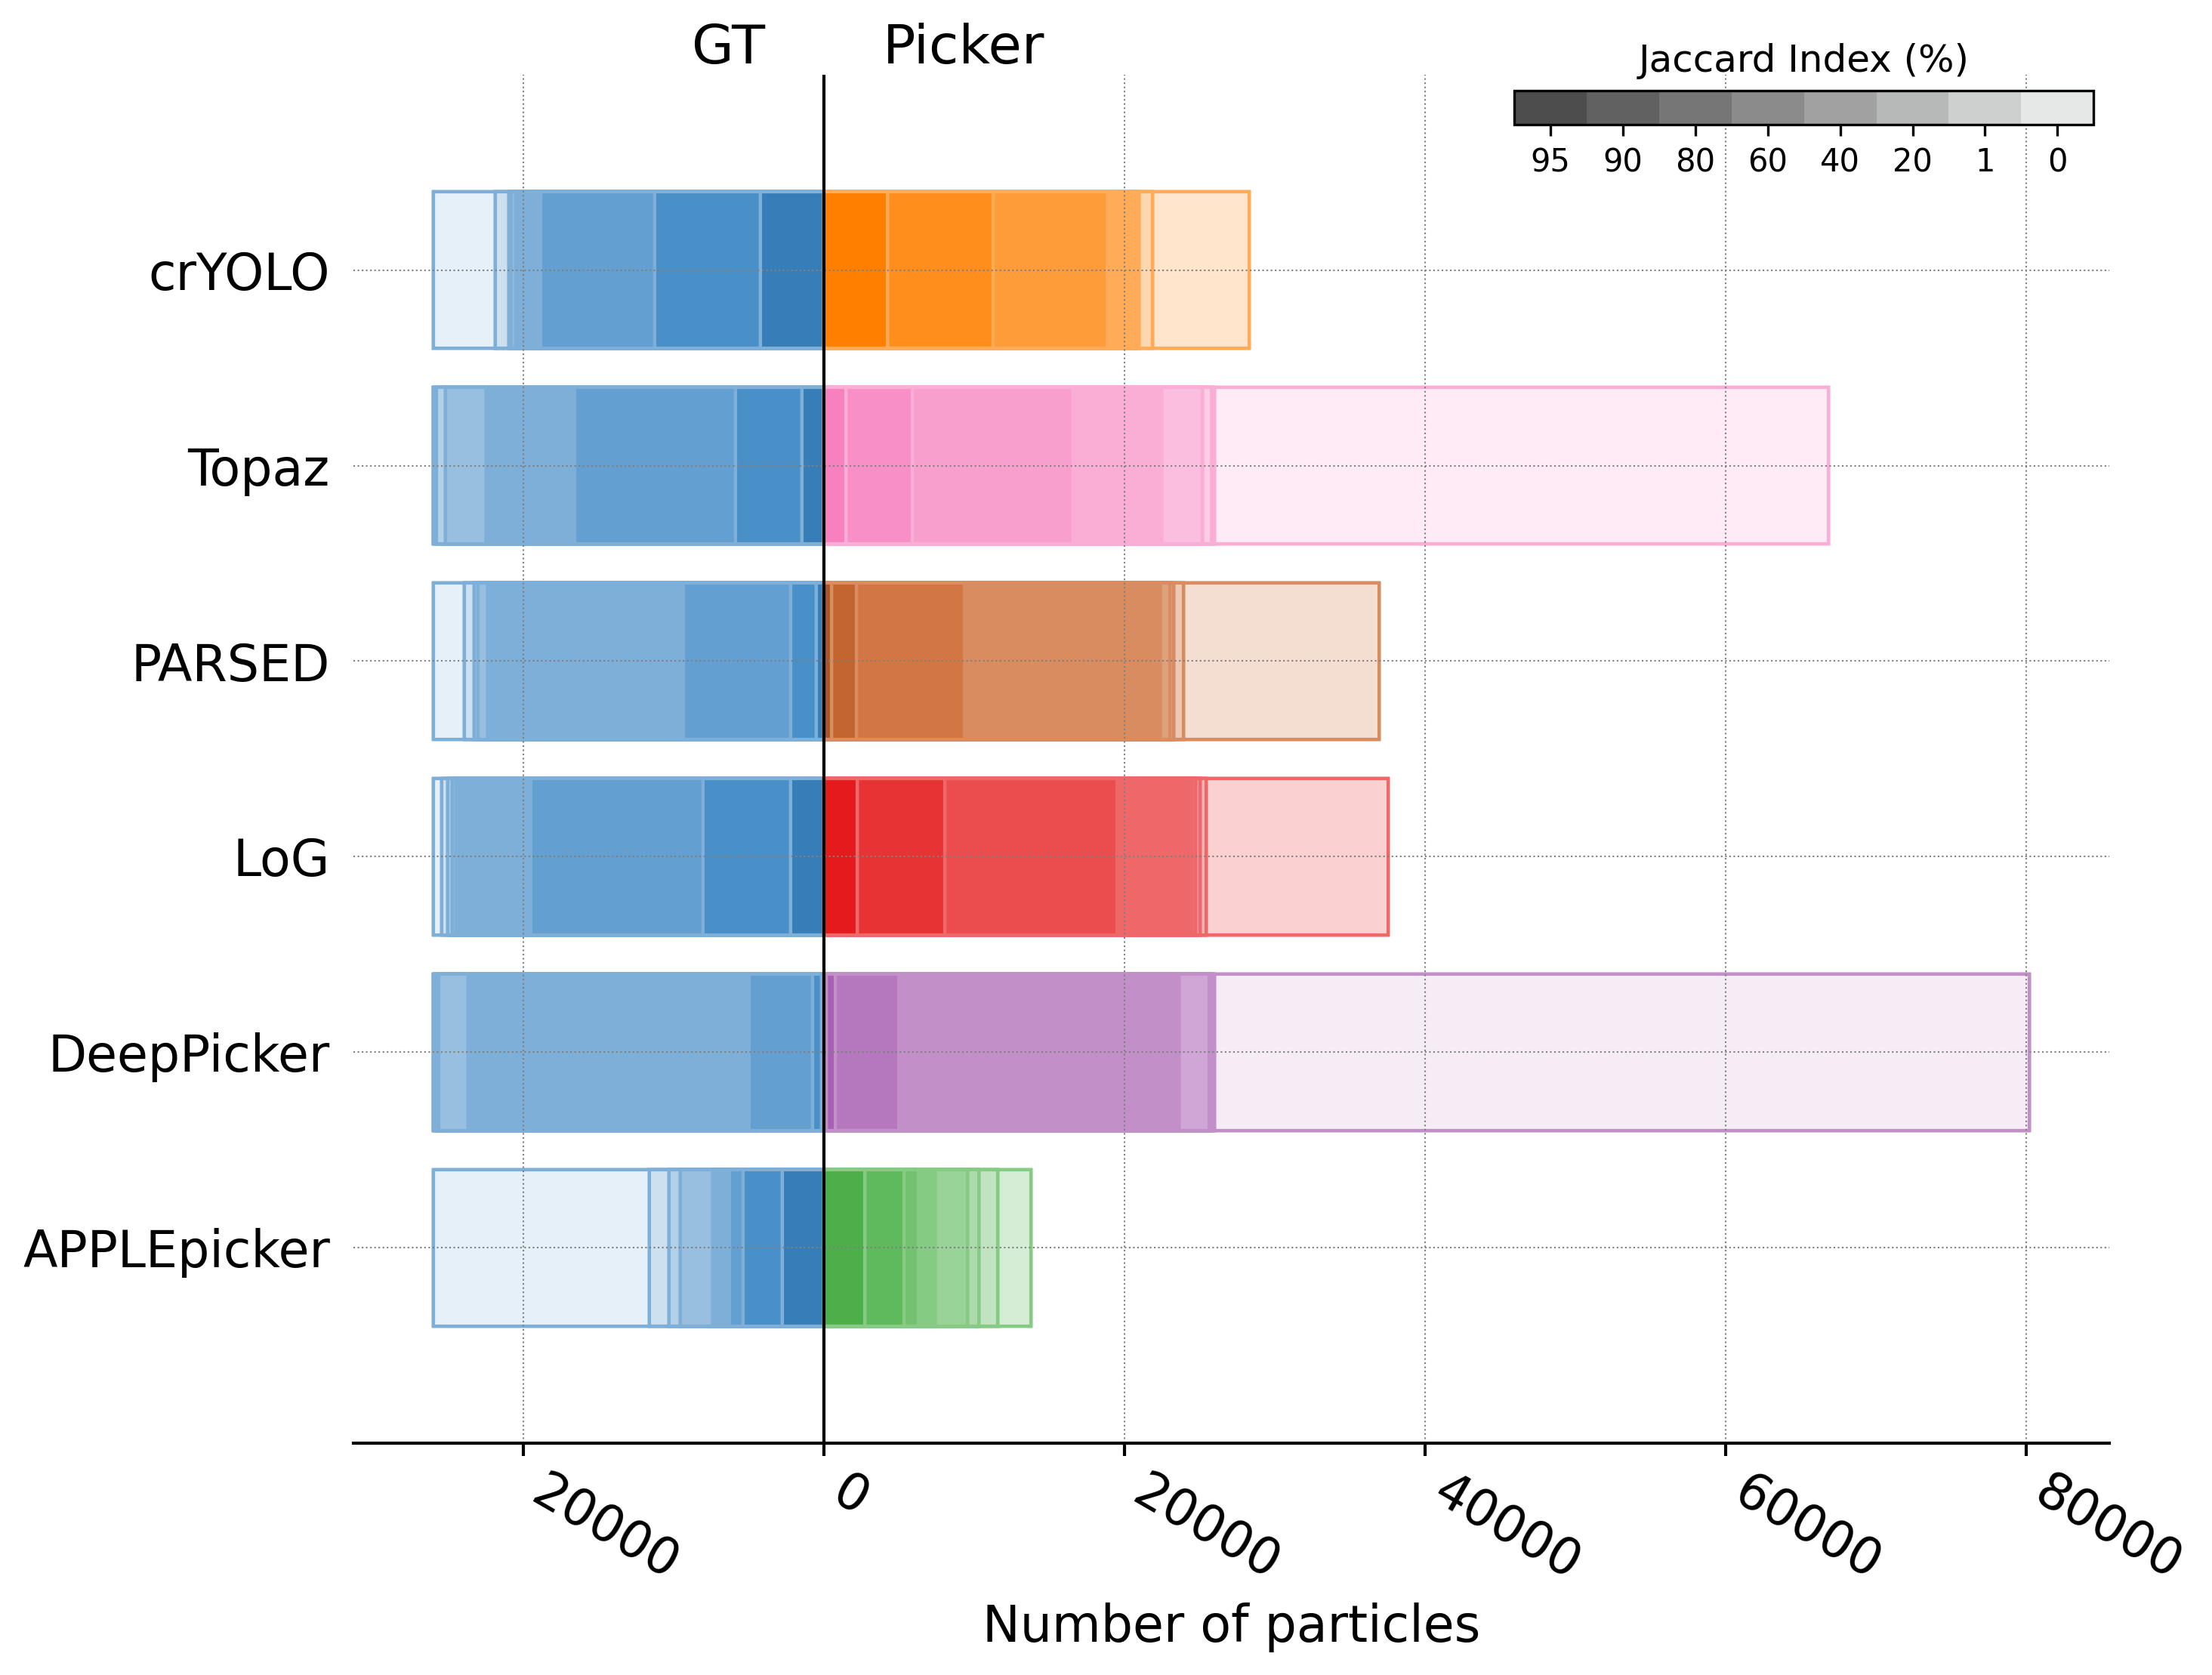

In [44]:
plot_stackedbar()

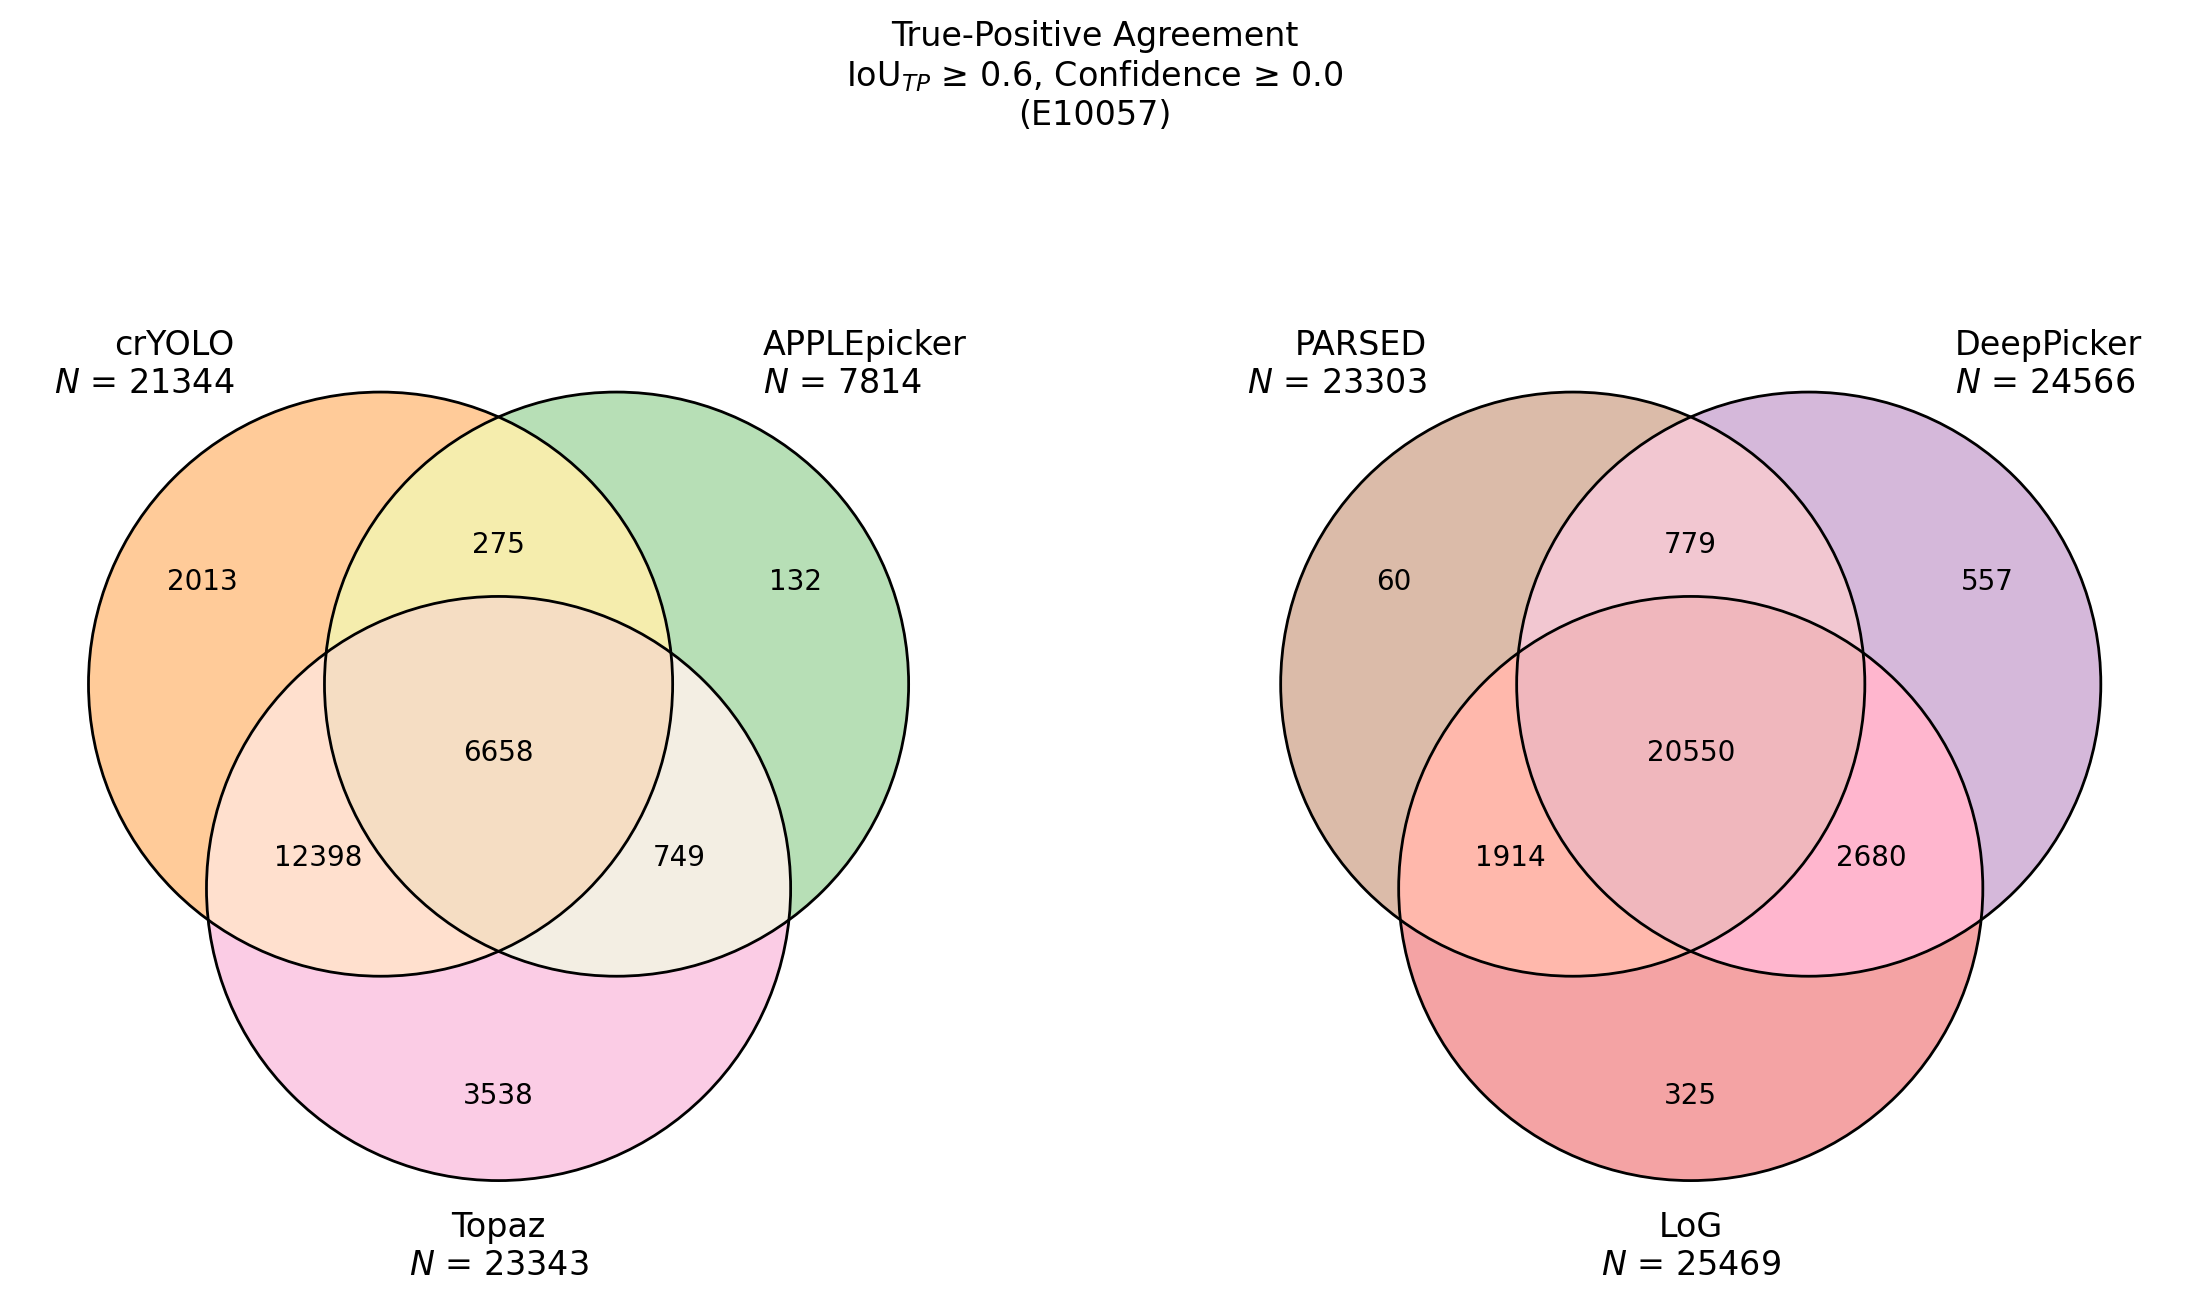

In [8]:
plot_tpvenn(None)

## Per-micrograph plots

In [ ]:
# for row in tqdm(file_matches):
#     plot_jac(row["mrc"])